In [1]:
## package setup and import
import numpy as np
import datajoint as dj
import pandas as pd
import matplotlib.pyplot as plt
import os
import glob
import datetime
from scipy.io import loadmat

In [2]:
# path = '/Users/jbuss/Code/datapipeline'
# files = os.listdir(path)
folder = os.getcwd()
print(folder)

C:\Users\jbuss\Code\Bpod\Analysis


In [9]:
## datajoint setup/import for database management
dj.__version__

dj.config['database.host'] = '127.0.0.1'
dj.config['database.port'] = 3306
dj.config['database.user'] = 'root'
dj.config['database.password'] = 'simple'
dj.config['fetch_format'] = 'array'
dj.config['enable_python_native_blobs'] = True 


connection = dj.conn()
connection

In [5]:
dj.config['stores'] = {
    'raw_data':{
        'protocol':'file',
        'location': os.path.join(folder,'raw_data')
    }
}

dj.config.save_global()

In [6]:
datafiles = []
filenames = []
for file in glob.glob(r"C:\Users\jbuss\Dropbox\BpodInfoseek\Data\JB*\TestInfoseek\Session Data\*.mat"):
        filenames.append(file[file.find('JB',45):])
        datafiles.append(file)

In [14]:
# schema.drop(True)
schema = dj.schema('behavioral')
schema.drop(True)
schema = dj.schema('behavioral')

In [15]:
@schema
class Mice(dj.Manual): ## Manual entry table for mouse identification/attribute labelling
    definition = """
    mouse_id : varchar(100) 
    ---
    sex = 'U': enum('F','M','U')
    
    geno = 'C57BL6' : varchar(50)
    imaging = null : int
    """

#     DOB = null : date  # YYYY-MM-DD


In [17]:
# format for entry of new mouse with new attributes, load later on will create new mouse if not previously entered but will be missing experimental params
mice = Mice()

mice.insert([{'mouse_id' : 'JB366', 'sex' : 'M'},{'mouse_id' : 'JB367','sex' :'F'},{'mouse_id' : 'JB368', 'sex' : 'M'},{'mouse_id' : 'JB369', 'sex' : 'M'}],skip_duplicates=True)
mice

# dj.ERD(schema)

mouse_id,sex,geno,imaging
JB366,M,C57BL6,None
JB367,F,C57BL6,None
JB368,M,C57BL6,None
JB369,M,C57BL6,None


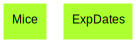

In [18]:
# any dates where sessions are logged and any associated mice are compiled

@schema
class ExpDates(dj.Manual):
    definition = """
    mouse_id : varchar(50)
    date : varchar(50)
    """
    
    
    def newDate(self,datafile):
        data = loadmat(datafile)
        filename = datafile[datafile.find('JB',45):]
        mouse_id = filename.split('_')[0]
        date = data['SessionData']['Info'][0][0][0][0][1][0]
        ExpDates.insert1({'mouse_id':mouse_id,'date':date},skip_duplicates=True)

dj.ERD(schema)

In [19]:
# datafiles associated with specific testing dates and times with what associated file name

@schema
class TestingSession(dj.Manual): ## Manual entry table for each recording session -- want to automate (imported data table - import table characteristics from recording files)
    definition = """
    -> Mice
    -> ExpDates
    time : varchar(50)
    datafile : varchar(200)
    ---
    comments = null : varchar(1000)
    """



    def insertSession(self,datafile):
        data = loadmat(datafile)
        filename = datafile[datafile.find('JB',45):]
        mouse_id = filename.split('_')[0]
        date = data['SessionData']['Info'][0][0][0][0][1][0]
        time = data['SessionData']['Info'][0][0][0][0][2][0]
        settings = pd.DataFrame(data['SessionData']['TrialSettings'][0][0][0])
        init_settings = pd.DataFrame(settings.iloc[0])
        final_settings = pd.DataFrame(settings.iloc[len(settings)-1])
        TestingSession.insert1({'mouse_id':mouse_id,'date':date,'time':time,'datafile':datafile},skip_duplicates=True)

In [20]:
# datafiles associated with specific testing dates and times with what associated file name

@schema
class TestingSession(dj.Manual): ## Manual entry table for each recording session -- want to automate (imported data table - import table characteristics from recording files)
    definition = """
    -> Mice
    -> ExpDates
    time : varchar(50)
    datafile : varchar(200)
    ---
    comments = null : varchar(1000)
    """



    def insertSession(self,datafile):
        data = loadmat(datafile)
        filename = datafile[datafile.find('JB',45):]
        mouse_id = filename.split('_')[0]
        date = data['SessionData']['Info'][0][0][0][0][1][0]
        time = data['SessionData']['Info'][0][0][0][0][2][0]
        settings = pd.DataFrame(data['SessionData']['TrialSettings'][0][0][0])
        init_settings = pd.DataFrame(settings.iloc[0])
        final_settings = pd.DataFrame(settings.iloc[len(settings)-1])
        TestingSession.insert1({'mouse_id':mouse_id,'date':date,'time':time,'datafile':datafile},skip_duplicates=True)

In [22]:
# list raw data and trial settings 

@schema
class SessionData(dj.Imported):
    definition = """
    -> Mice
    -> TestingSession
    ---
    raw_data : longblob
    init_settings : longblob
    final_settings : longblob
    """
    
    def make(self,key):
        data = loadmat((TestingSession & key).fetch1()['datafile'])
        settings = pd.DataFrame(data['SessionData']['TrialSettings'][0][0][0])
        key['raw_data'] = pd.DataFrame(data['SessionData'][0])
        key['init_settings'] = pd.DataFrame(settings.iloc[0])
        key['final_settings'] = pd.DataFrame(settings.iloc[len(settings)-1])
        self.insert1(key)
        

In [24]:
# enter data into manual entry tables

def newEntry(datafile):
    filename = datafile[datafile.find('JB',45):]
    mouse_id = filename.split('_')[0]
    Mice.insert1({'mouse_id': mouse_id},skip_duplicates = True)
    ExpDates().newDate(datafile)
    TestingSession().insertSession(datafile)



    
for i in datafiles: 
    try:
        newEntry(i)
        print(i + ': loaded')
    except ValueError:
        print(i + ': incomplete file')



# for file in os.listdir(r"C:\Users\ashwi\Dropbox\BpodInfoseek\Data\JB366\CenterTraining\Session Data"):
#     if file.startswith("JB"):
#         print(os.listdir(r"C:\Users\ashwi\Dropbox\BpodInfoseek\Data\JB366\CenterTraining\Session Data"))
#         newEntry(os.path.join(r"C:\Users\ashwi\Dropbox\BpodInfoseek\Data\JB366\CenterTraining\Session Data",file),str())
# dj.ERD(schema)


C:\Users\jbuss\Dropbox\BpodInfoseek\Data\JB366\TestInfoseek\Session Data\JB366_TestInfoseek_20200831_140956.mat: loaded
C:\Users\jbuss\Dropbox\BpodInfoseek\Data\JB366\TestInfoseek\Session Data\JB366_TestInfoseek_20200831_142200.mat: incomplete file
C:\Users\jbuss\Dropbox\BpodInfoseek\Data\JB366\TestInfoseek\Session Data\JB366_TestInfoseek_20200831_142331.mat: loaded
C:\Users\jbuss\Dropbox\BpodInfoseek\Data\JB366\TestInfoseek\Session Data\JB366_TestInfoseek_20200831_143516.mat: loaded
C:\Users\jbuss\Dropbox\BpodInfoseek\Data\JB366\TestInfoseek\Session Data\JB366_TestInfoseek_20200901_122435.mat: loaded
C:\Users\jbuss\Dropbox\BpodInfoseek\Data\JB366\TestInfoseek\Session Data\JB366_TestInfoseek_20200901_124714.mat: loaded
C:\Users\jbuss\Dropbox\BpodInfoseek\Data\JB366\TestInfoseek\Session Data\JB366_TestInfoseek_20200901_130932.mat: loaded
C:\Users\jbuss\Dropbox\BpodInfoseek\Data\JB366\TestInfoseek\Session Data\JB366_TestInfoseek_20200902_120322.mat: loaded
C:\Users\jbuss\Dropbox\BpodInfo

C:\Users\jbuss\Dropbox\BpodInfoseek\Data\JB368\TestInfoseek\Session Data\JB368_TestInfoseek_20200904_151752.mat: loaded
C:\Users\jbuss\Dropbox\BpodInfoseek\Data\JB368\TestInfoseek\Session Data\JB368_TestInfoseek_20200904_152329.mat: loaded
C:\Users\jbuss\Dropbox\BpodInfoseek\Data\JB368\TestInfoseek\Session Data\JB368_TestInfoseek_20200904_152849.mat: loaded
C:\Users\jbuss\Dropbox\BpodInfoseek\Data\JB368\TestInfoseek\Session Data\JB368_TestInfoseek_20200904_154422.mat: loaded
C:\Users\jbuss\Dropbox\BpodInfoseek\Data\JB368\TestInfoseek\Session Data\JB368_TestInfoseek_20200909_140757.mat: loaded
C:\Users\jbuss\Dropbox\BpodInfoseek\Data\JB368\TestInfoseek\Session Data\JB368_TestInfoseek_20200909_141324.mat: loaded
C:\Users\jbuss\Dropbox\BpodInfoseek\Data\JB368\TestInfoseek\Session Data\JB368_TestInfoseek_20200909_142554.mat: loaded
C:\Users\jbuss\Dropbox\BpodInfoseek\Data\JB368\TestInfoseek\Session Data\JB368_TestInfoseek_20200909_143534.mat: loaded
C:\Users\jbuss\Dropbox\BpodInfoseek\Data

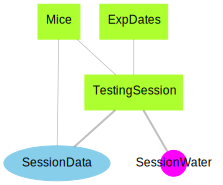

In [25]:
# create table that compiles water and number of trials per experimental session

@schema
class SessionWater(dj.Computed):
    definition = """
    -> TestingSession
    ---
    water_vol_ul : int
    drop_size : int
    num_trials : int
    """
    
    def make(self,key):
        dropVol = 4 # mL
        data = (SessionData & key).fetch1()['raw_data']
        trialEvents = data['RawEvents'][0][0][0][0][0]
        numDrops = []
        numTrials = len(trialEvents)
        for i in np.arange(len(trialEvents)):
            try:
                dropCount = len(trialEvents[i][0][0][1]['GlobalTimer3_End'][0][0][0])
            except ValueError:
                try:
                    dropCount = len(trialEvents[i][0][0][1]['GlobalTimer4_End'][0][0][0])
                except ValueError:
                    dropCount = 0

            numDrops.append(dropCount)

        totalDrops = sum(numDrops)
        
        key['water_vol_ul'] = totalDrops*dropVol
        key['drop_size'] = dropVol
        key['num_trials'] = numTrials
        self.insert1(key)
        
dj.ERD(schema)

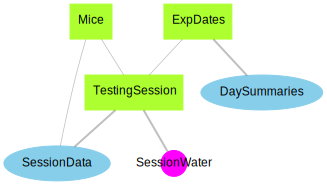

In [26]:
# table with day summary of total water given through experimental trials for individual mice each day

@schema
class DaySummaries(dj.Imported):
    definition = """
    -> ExpDates
    ---
    total_water_ul : int
    """
    
    def make(self,key):
        mouseID = (ExpDates & key).fetch()['mouse_id']
        dates = (ExpDates & key).fetch()['date']
        for i in mouseID:
            for j in dates:
                dayWater = sum((SessionWater & 'mouse_id = ' + str('"' + i + '"') & 'date = ' + str('"' + j + '"')).fetch()['water_vol_ul'])
                key['total_water_ul'] = dayWater
        self.insert1(key)    

dj.ERD(schema)

In [27]:
@schema
class OutcomesPlot(dj.Computed):
    definition = """
    -> SessionData
    ---
    num_trials : int
    outcomes : longblob
    """
    
    def make(self,key):
        data = loadmat((TestingSession & key).fetch1()['datafile'])
        outcomes = pd.DataFrame(data['SessionData']['Outcomes'][0][0][0])
        numTrials = len(outcomes)
        key['num_trials'] = numTrials
        key['outcomes'] = outcomes
        self.insert1(key)

# dj.ERD(schema)

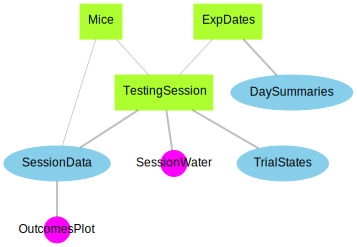

In [28]:
@schema
class TrialStates(dj.Imported):
    definition = """
    -> TestingSession
    ---
    start_trial : blob
    wait_for_center : blob
    center_delay : blob
    center_odor : blob
    center_post_odor_delay : blob
    go_cue : blob
    response : blob
    wait_for_odor_l : blob
    wait_for_odor_r : blob
    odor_left : blob
    odor_right : blob
    reward_delay_left : blob
    reward_delay_right : blob
    left_port_check : blob
    left_not_present : blob
    right_not_present : blob
    left_big_reward : blob
    left_small_reward : blob
    right_big_reward : blob
    right_small_reward : blob
    outcome_delivery : blob
    incorrect_left : blob
    incorrect_right : blob
    no_choice : blob
    incorrect : blob
    timeout_odor : blob
    timeout_reward_delay : blob
    timeout_outcome : blob
    intertrial_interval : blob
    """    
#     right_port_check : blob

    
    def make(self,key):
        trials = loadmat((TestingSession & key).fetch1()['datafile'])['SessionData']['RawEvents'][0][0][0][0][0][0]
        for i in np.arange(len(trials)):
                trialstate = trials[i][0][0][0][0]
                start_trial[i] = (trialstate['StartTrial'])
                wait_for_center[i] = (trialstate['WaitForCenter'])
                center_delay[i] = (trialstate['CenterDelay'])
                center_odor[i] = (trialstate['CenterOdor'])
                center_post_odor_delay[i] = (trialstate['CenterPostOdorDelay'])
                go_cue[i] = (trialstate['GoCue'])
                response[i] = (trialstate['Response'])
                wait_for_odor_l[i] = (trialstate['WaitForOdorLeft'])
                wait_for_odor_r[i] = (trialstate['WaitForOdorRight'])
                odor_left[i] = (trialstate['OdorLeft'])
                odor_right[i] = (trialstate['OdorRight'])
                reward_delay_left[i] = (trialstate['RewardDelayLeft'])
                reward_delay_right[i] = (trialstate['RewardDelayRight'])
                left_port_check[i] = (trialstate['LeftPortCheck'])
        #             right_port_check[i] = pd.DataFrame(trialstate['RightPortCheck'])
                left_not_present[i] = (trialstate['LeftNotPresent'])
                right_not_present[i] = (trialstate['RightNotPresent'])
                left_big_reward[i] = (trialstate['LeftBigReward'])
                left_small_reward[i] = (trialstate['LeftSmallReward'])
                right_big_reward[i] = (trialstate['RightBigReward'])
                right_small_reward[i] = (trialstate['RightSmallReward'])
                outcome_delivery[i] = (trialstate['OutcomeDelivery'])
                incorrect_left[i] = (trialstate['IncorrectLeft'])
                incorrect_right[i] = (trialstate['IncorrectRight'])
                no_choice[i] = (trialstate['NoChoice'])
                incorrect[i] = (trialstate['Incorrect'])
                timeout_odor[i] = (trialstate['TimeoutOdor'])
                timeout_reward_delay[i] = (trialstate['TimeoutRewardDelay'])
                timeout_outcome[i]  = (trialstate['TimeoutOutcome'])
                intertrial_interval[i] = (trialstate['InterTrialInterval'])
        
            
            
            
        key['start_trial'] = start_trial
        key['wait_for_center'] = wait_for_center
        key['center_delay'] = center_delay
        key['center_odor'] = center_odor
        key['center_post_odor_delay'] = center_post_odor_delay
        key['go_cue'] = go_cue
        key['response'] = response
        key['wait_for_odor_l'] = wait_for_odor_l
        key['wait_for_odor_r'] = wait_for_odor_r
        key['odor_left'] = odor_left
        key['odor_right'] = odor_right
        key['reward_delay_left'] = reward_delay_left
        key['reward_delay_right'] = reward_delay_right
        key['left_port_check'] = left_port_check
        key['left_not_present'] = left_not_present
#         key['right_port_check'] = right_port_check
        key['right_not_present'] = right_not_present
        key['left_big_reward'] = left_big_reward
        key['left_small_reward'] = left_small_reward
        key['right_big_reward'] = right_big_reward
        key['right_small_reward'] = right_small_reward
        key['outcome_delivery'] = outcome_delivery
        key['incorrect_left'] = incorrect_left
        key['incorrect_right'] = incorrect_right
        key['no_choice'] = no_choice
        key['incorrect'] = incorrect
        key['timeout_odor'] = timeout_odor
        key['timeout_reward_delay'] = timeout_reward_delay
        key['timeout_outcome'] = timeout_outcome
        key['intertrial_interval'] = intertrial_interval
        
        self.insert1(key)
        
dj.ERD(schema)

In [29]:
#populate initial imported/computed tables

SessionData.populate()
SessionWater.populate()
DaySummaries.populate()
OutcomesPlot.populate()
# TrialStates.populate()


In [30]:
SessionData()

mouse_id,date,time,datafile,raw_data,init_settings,final_settings
JB366,01-Sep-2020,12:31:51,C:\Users\jbuss\Dropbox\BpodInfoseek\Data\JB366\TestInfoseek\Session Data\JB366_TestInfoseek_20200901_122435.mat,=BLOB=,=BLOB=,=BLOB=
JB366,01-Sep-2020,12:47:45,C:\Users\jbuss\Dropbox\BpodInfoseek\Data\JB366\TestInfoseek\Session Data\JB366_TestInfoseek_20200901_124714.mat,=BLOB=,=BLOB=,=BLOB=
JB366,01-Sep-2020,13:11:05,C:\Users\jbuss\Dropbox\BpodInfoseek\Data\JB366\TestInfoseek\Session Data\JB366_TestInfoseek_20200901_130932.mat,=BLOB=,=BLOB=,=BLOB=
JB366,02-Sep-2020,12:08:04,C:\Users\jbuss\Dropbox\BpodInfoseek\Data\JB366\TestInfoseek\Session Data\JB366_TestInfoseek_20200902_120322.mat,=BLOB=,=BLOB=,=BLOB=
JB366,02-Sep-2020,12:17:26,C:\Users\jbuss\Dropbox\BpodInfoseek\Data\JB366\TestInfoseek\Session Data\JB366_TestInfoseek_20200902_121653.mat,=BLOB=,=BLOB=,=BLOB=
JB366,03-Sep-2020,12:46:38,C:\Users\jbuss\Dropbox\BpodInfoseek\Data\JB366\TestInfoseek\Session Data\JB366_TestInfoseek_20200903_124237.mat,=BLOB=,=BLOB=,=BLOB=
JB366,03-Sep-2020,12:50:31,C:\Users\jbuss\Dropbox\BpodInfoseek\Data\JB366\TestInfoseek\Session Data\JB366_TestInfoseek_20200903_124906.mat,=BLOB=,=BLOB=,=BLOB=
JB366,03-Sep-2020,12:55:01,C:\Users\jbuss\Dropbox\BpodInfoseek\Data\JB366\TestInfoseek\Session Data\JB366_TestInfoseek_20200903_125411.mat,=BLOB=,=BLOB=,=BLOB=
JB366,03-Sep-2020,13:03:56,C:\Users\jbuss\Dropbox\BpodInfoseek\Data\JB366\TestInfoseek\Session Data\JB366_TestInfoseek_20200903_130203.mat,=BLOB=,=BLOB=,=BLOB=
JB366,04-Sep-2020,13:46:03,C:\Users\jbuss\Dropbox\BpodInfoseek\Data\JB366\TestInfoseek\Session Data\JB366_TestInfoseek_20200904_134451.mat,=BLOB=,=BLOB=,=BLOB=


In [31]:
SessionWater()

mouse_id,date,time,datafile,water_vol_ul,drop_size,num_trials
JB366,01-Sep-2020,12:31:51,C:\Users\jbuss\Dropbox\BpodInfoseek\Data\JB366\TestInfoseek\Session Data\JB366_TestInfoseek_20200901_122435.mat,100,4,25
JB366,01-Sep-2020,12:47:45,C:\Users\jbuss\Dropbox\BpodInfoseek\Data\JB366\TestInfoseek\Session Data\JB366_TestInfoseek_20200901_124714.mat,204,4,51
JB366,01-Sep-2020,13:11:05,C:\Users\jbuss\Dropbox\BpodInfoseek\Data\JB366\TestInfoseek\Session Data\JB366_TestInfoseek_20200901_130932.mat,28,4,8
JB366,02-Sep-2020,12:08:04,C:\Users\jbuss\Dropbox\BpodInfoseek\Data\JB366\TestInfoseek\Session Data\JB366_TestInfoseek_20200902_120322.mat,140,4,36
JB366,02-Sep-2020,12:17:26,C:\Users\jbuss\Dropbox\BpodInfoseek\Data\JB366\TestInfoseek\Session Data\JB366_TestInfoseek_20200902_121653.mat,200,4,50
JB366,03-Sep-2020,12:46:38,C:\Users\jbuss\Dropbox\BpodInfoseek\Data\JB366\TestInfoseek\Session Data\JB366_TestInfoseek_20200903_124237.mat,68,4,17
JB366,03-Sep-2020,12:50:31,C:\Users\jbuss\Dropbox\BpodInfoseek\Data\JB366\TestInfoseek\Session Data\JB366_TestInfoseek_20200903_124906.mat,100,4,26
JB366,03-Sep-2020,12:55:01,C:\Users\jbuss\Dropbox\BpodInfoseek\Data\JB366\TestInfoseek\Session Data\JB366_TestInfoseek_20200903_125411.mat,116,4,29
JB366,03-Sep-2020,13:03:56,C:\Users\jbuss\Dropbox\BpodInfoseek\Data\JB366\TestInfoseek\Session Data\JB366_TestInfoseek_20200903_130203.mat,100,4,25
JB366,04-Sep-2020,13:46:03,C:\Users\jbuss\Dropbox\BpodInfoseek\Data\JB366\TestInfoseek\Session Data\JB366_TestInfoseek_20200904_134451.mat,84,4,21


In [32]:
DaySummaries()

mouse_id,date,total_water_ul
JB366,01-Sep-2020,332
JB366,02-Sep-2020,340
JB366,03-Sep-2020,384
JB366,04-Sep-2020,172
JB366,08-Sep-2020,0
JB366,09-Sep-2020,284
JB366,10-Sep-2020,92
JB366,31-Aug-2020,160
JB367,01-Sep-2020,64
JB367,02-Sep-2020,168


In [34]:
DaySummaries & 'date = "10-Sep-2020"'

mouse_id,date,total_water_ul
JB366,10-Sep-2020,92
JB367,10-Sep-2020,128
JB368,10-Sep-2020,440
JB369,10-Sep-2020,612
